In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from bosonStar import *
from util import *

from ctypes import *
file = "./testing.so"
my_func = CDLL(file)

#Case: Middle
massInCU = 2e-77
aInCU = 1e-73
totalMassInCU = 0.1
dtInCU = 2500.0
bigT = 3000

/home/kklee/anaconda3/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


A2=  -0.3197640202007044  X= 20.65212130424261
A2=  -0.4847073570486533  X= 20.0997201994404
A2=  -0.49962370647516496  X= 40.0
A2=  -0.5019378672698831  X= 16.740033480066963
A2=  -0.5018381151222431  X= 21.703563407126815
A2=  -0.501873065422044  X= 15.347950695901392
A2=  -0.5019294650803621  X= 13.257546515093031
A2=  -0.5019294650803621  X= 13.257546515093031
MU= 0.31816194102760903 MASS= 0.09999058237901089
FAR POINT: 164264 500000


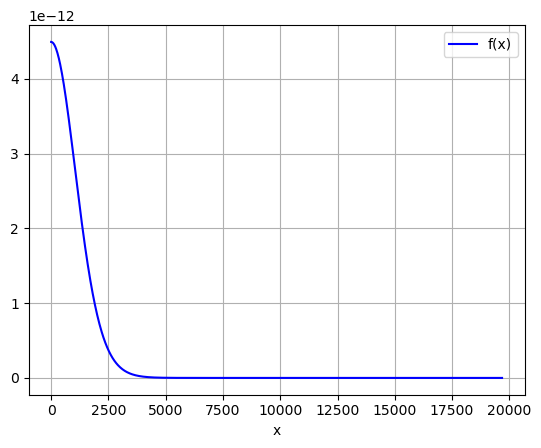

(2500,)


In [2]:
bosonStar = outputProfile(massInCU, aInCU, totalMassInCU, 500)
x = bosonStar["x"]
psi = bosonStar["profile"]

dx = x[1]-x[0]
for i in range(2000):
    x = np.append(x, x[-1]+dx)
    psi = np.append(psi, psi[-1])

print(x.shape)

In [3]:
totalMass = massSIToPlanckUnit(massCodeUnitToSI(totalMassInCU))
m = massSIToPlanckUnit(massCodeUnitToSI(massInCU))
a = lengthSIToPlanckUnit(lengthCodeUnitToSI(aInCU))
N = totalMass/m
Ra = np.sqrt(a/m/m/m)
omegaA = m*m/np.abs(a)
epsilon = 1.0/omegaA/m/Ra/Ra
a0 = np.sqrt(1.0/omegaA/m)
delta = 4.0*np.pi*a*N/a0
GM = totalMass/Ra/Ra/Ra/omegaA/omegaA

print("R:", Ra)
print("Omega:" ,omegaA)
print("Epsilon (Should be 1):", epsilon)
print("Delta:", delta)
print("New G:", GM)

R: 3.8684718785837514e+40
Omega: 3.656129092998465e-43
Epsilon (Should be 1): 1.0000000000000002
Delta: 14.839459489461666
New G: 1.180886665279879


In [4]:
x = lengthSIToPlanckUnit(lengthCodeUnitToSI(x))/Ra
psi = np.sqrt(densitySIToPlanckUnit(densityCodeUnitToSI(psi))/totalMass)*np.power(Ra, 3.0/2.0)
normalization = scipy.integrate.simpson(4.0*np.pi*x*x*np.absolute(psi)*np.absolute(psi), x=x)
psi = psi/normalization
psi = psi.astype(complex)

for index, value in enumerate(psi):
    if(value<1e-5):
        psi[index] = 0.0

psi = x*psi

size = len(psi)
dt = timeSIToPlanckUnit(timeCodeUnitToSI(dtInCU))*omegaA
dx = x[1]-x[0]

print(psi)
print("DX:", dx)
print("DT:", dt)

[0.00271691+0.j 0.00814509+0.j 0.0135564 +0.j ... 0.        +0.j
 0.        +0.j 0.        +0.j]
DX: 0.09305020722929994
DT: 0.08351027137908527


In [5]:
T = np.zeros((size,size)).astype(complex)
TSph = np.zeros((size,size)).astype(complex)
Q = np.zeros((size,size)).astype(complex)
V2Grav = np.zeros((size,size)).astype(complex)
I = np.identity(size).astype(complex)
phi = np.zeros((size))

In [6]:
def setupT():
    global T
    for i in range(size):
        if i==0:
            T[i][i] = -3.0
            T[i][i+1] = 1.0
        elif i==size-1:
            T[i][i] = -1.0
            T[i][i-1] = 1.0
        else:
            T[i][i] = -2.0
            T[i][i+1] = 1.0
            T[i][i-1] = 1.0

    T = -1.0/2.0/dx/dx*T

def setupQ():
    global Q
    for i in range(size):
        Q[i][i] = delta*np.absolute(psi[i]/x[i])*np.absolute(psi[i]/x[i])

def setupV2Grav():
    global V2Grav, phi

    rho = np.absolute(psi)*np.absolute(psi)/x/x
    rho_c = (c_double * size)(*rho)
    phi_c = (c_double * size)(*np.absolute(phi))
    my_func.findGravRho(rho_c, phi_c, c_int(size), c_double(dx))
    for i in range(size):
        phi[i] = phi_c[i] * GM

    for i in range(size):
        V2Grav[i][i] = phi[i]

def setupU1U2():
    global U1, U2
    U1 = I + 1.0j*dt/2.0*(T+Q+V2Grav)
    U2 = I - 1.0j*dt/2.0*(T+Q+V2Grav)

In [7]:
def findMass():
    for i in range(size):
        if(i != 0):
            temp = scipy.integrate.simpson(4.0*np.pi*np.absolute(psi[:i])*np.absolute(psi[:i]), x=x[:i])
            if(temp > 0.99):
                return i
    return size-1

[-3.54985987e-07 -1.52526048e-07  2.43890328e-08 -1.34784656e-09
 -1.73150700e-09 -2.11381905e-09 -2.49448712e-09 -2.87357613e-09
 -3.25052100e-09 -3.62493075e-09 -3.99657949e-09 -4.36506260e-09
 -4.72998150e-09 -5.09095254e-09 -5.44755498e-09 -5.79935935e-09
 -6.14590911e-09 -6.48674461e-09 -6.82140439e-09 -7.14939518e-09
 -7.47022390e-09 -7.78342552e-09 -8.08853763e-09 -8.38506307e-09
 -8.67249393e-09 -8.95040130e-09 -9.21837453e-09 -9.47592863e-09
 -9.72265613e-09 -9.95824572e-09 -1.01823204e-08 -1.03945093e-08
 -1.05945816e-08 -1.07823241e-08 -1.09574531e-08 -1.11198107e-08
 -1.12693437e-08 -1.14059207e-08 -1.15294609e-08 -1.16400246e-08
 -1.17376667e-08 -1.18224165e-08 -1.18944183e-08 -1.19538808e-08
 -1.20009710e-08 -1.20359166e-08 -1.20590198e-08 -1.20705762e-08
 -1.20708965e-08 -1.20603529e-08 -1.20393715e-08 -1.20083547e-08
 -1.19676562e-08 -1.19176924e-08 -1.18589763e-08 -1.17919810e-08
 -1.17171214e-08 -1.16348542e-08 -1.15456637e-08 -1.14500220e-08
 -1.13483664e-08 -1.12411

/tmp/ipykernel_15084/1027521224.py:16: RuntimeWarning: divide by zero encountered in divide
  quantumPotential = -hBarCU*hBarCU/2.0/massInCU*(d2Rhodx + 2.0/(x*Ra*1.616e-35*100*6.77193e-6)*dRhodx)/np.sqrt(rhoTemp)
/tmp/ipykernel_15084/1027521224.py:16: RuntimeWarning: invalid value encountered in divide
  quantumPotential = -hBarCU*hBarCU/2.0/massInCU*(d2Rhodx + 2.0/(x*Ra*1.616e-35*100*6.77193e-6)*dRhodx)/np.sqrt(rhoTemp)
/tmp/ipykernel_15084/1027521224.py:18: RuntimeWarning: divide by zero encountered in divide
  plt.plot(x*Ra*1.616e-35*100*6.77193e-6, pressureGradient/rhoTemp)
/tmp/ipykernel_15084/1027521224.py:18: RuntimeWarning: invalid value encountered in divide
  plt.plot(x*Ra*1.616e-35*100*6.77193e-6, pressureGradient/rhoTemp)
/home/kklee/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


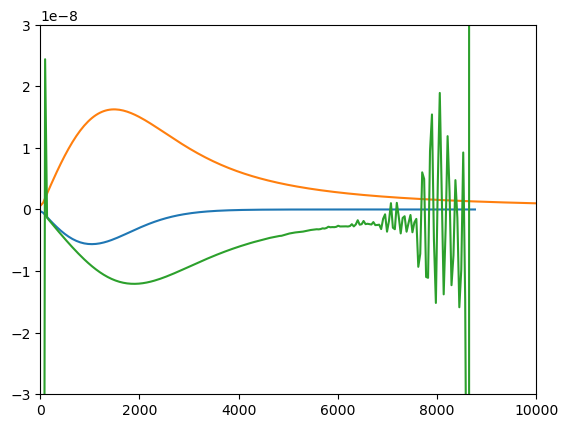

In [8]:
#Temporary
#massInCU = 2e-77
#aInCU = 1e-73
#totalMassInCU = 0.1
hBarInCU = 1.1977151493389159e-76
setupV2Grav()
np.set_printoptions(threshold=np.inf)

rhoTemp = (np.absolute(psi)/x)*(np.absolute(psi)/x)/Ra/Ra/Ra*totalMass*5.1550e96*0.001*1.619e-18
pressure = 2.0*np.pi*aInCU*hBarInCU*hBarInCU/massInCU/massInCU/massInCU*rhoTemp*rhoTemp
pressureGradient = np.gradient(pressure, x*Ra*1.616e-35*100*6.77193e-6)
gravitationalPotential = phi*Ra*Ra*omegaA*omegaA*1.616e-35*100*6.77193e-6*1.616e-35*100*6.77193e-6/5.391e-44/5.391e-44/2.03017e5/2.03017e5

dRhodx = np.gradient(np.sqrt(rhoTemp), x*Ra*1.616e-35*100*6.77193e-6)
d2Rhodx = np.gradient(dRhodx, x*Ra*1.616e-35*100*6.77193e-6)
quantumPotential = -hBarCU*hBarCU/2.0/massInCU*(d2Rhodx + 2.0/(x*Ra*1.616e-35*100*6.77193e-6)*dRhodx)/np.sqrt(rhoTemp)

plt.plot(x*Ra*1.616e-35*100*6.77193e-6, pressureGradient/rhoTemp)
plt.plot(x*Ra*1.616e-35*100*6.77193e-6, np.gradient(gravitationalPotential, x*Ra*1.616e-35*100*6.77193e-6))
plt.plot(x*Ra*1.616e-35*100*6.77193e-6, np.gradient(quantumPotential, x*Ra*1.616e-35*100*6.77193e-6)/massInCU)

plt.xlim(0.0,10000.0)
plt.ylim(-3e-8,3e-8)
print(np.gradient(quantumPotential, x*Ra*1.616e-35*100*6.77193e-6)/massInCU)

0 0.0 0.08351027137908527 0.05839762281119632
[-1.72923858  0.56964883]


/tmp/ipykernel_15084/247593979.py:76: RuntimeWarning: divide by zero encountered in divide
  quantumPotential = -hBarCU*hBarCU/2.0/massInCU*(d2Rhodx + 2.0/(x*Ra*1.616e-35*100*6.77193e-6)*dRhodx)/np.sqrt(rhoTemp)
/tmp/ipykernel_15084/247593979.py:76: RuntimeWarning: invalid value encountered in divide
  quantumPotential = -hBarCU*hBarCU/2.0/massInCU*(d2Rhodx + 2.0/(x*Ra*1.616e-35*100*6.77193e-6)*dRhodx)/np.sqrt(rhoTemp)
/tmp/ipykernel_15084/247593979.py:78: RuntimeWarning: invalid value encountered in divide
  plt.plot(x*Ra*1.616e-35*100*6.77193e-6, pressureGradients/rhoTemp)


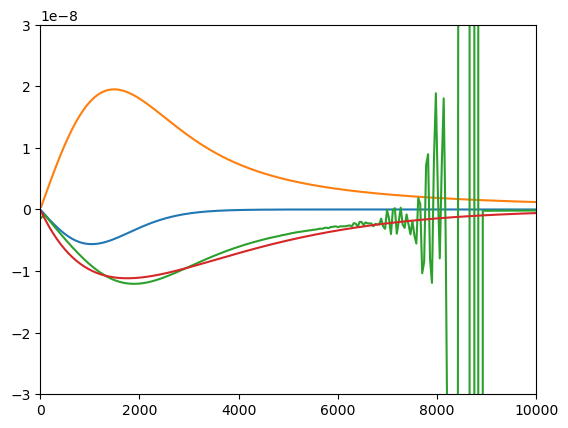

1 0.08351027137908527 0.1 0.05840156852574673
2 0.18351027137908527 0.1 0.0584084606143759
3 0.28351027137908524 0.1 0.058418282630042936
4 0.3835102713790852 0.1 0.05843101263299328
5 0.4835102713790852 0.1 0.05844662164958553
6 0.5835102713790852 0.1 0.05846507506770306
7 0.6835102713790852 0.1 0.05848633304735706
8 0.7835102713790851 0.1 0.058510349837815216
9 0.8835102713790851 0.1 0.0585370752243788
10 0.9835102713790851 0.1 0.0585664549711441
11 1.0835102713790852 0.1 0.058598430567500484
12 1.1835102713790853 0.1 0.05863294104562611
13 1.2835102713790854 0.1 0.05866992211015485
14 1.3835102713790854 0.1 0.05870930734313858
15 1.4835102713790855 0.1 0.05875102794651842
16 1.5835102713790856 0.1 0.058795015017039196
17 1.6835102713790857 0.1 0.05884119864799403
18 1.7835102713790858 0.1 0.05888950802252565
19 1.8835102713790859 0.1 0.05893987198543568
20 1.983510271379086 0.1 0.058992218827361415
21 2.083510271379086 0.1 0.05904647933578738
22 2.183510271379086 0.1 0.0591025841124

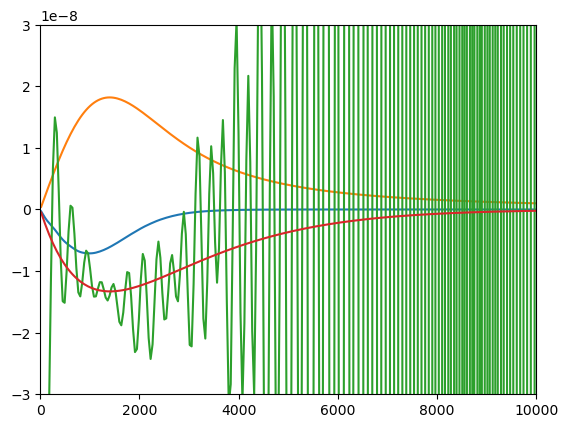

101 10.083510271379067 0.1 0.06356024361442432
102 10.183510271379067 0.1 0.06363334343651891
103 10.283510271379066 0.1 0.06369975402010546
104 10.383510271379066 0.1 0.06356692893965388
105 10.483510271379066 0.1 0.0636411184409097
106 10.583510271379065 0.1 0.06371477319161188
107 10.683510271379065 0.1 0.06358604584064322
108 10.783510271379065 0.1 0.063668196707961
109 10.883510271379064 0.1 0.06373895370057774
110 10.983510271379064 0.1 0.0636125314064315
111 11.083510271379064 0.1 0.06370721019527903
112 11.183510271379063 0.1 0.0637637771216187
113 11.283510271379063 0.1 0.06363931445796611
114 11.383510271379063 0.1 0.06374907709628416
115 11.483510271379062 0.1 0.06377991100298536
116 11.583510271379062 0.1 0.0636608777880525
117 11.683510271379062 0.1 0.06378568160137414
118 11.783510271379061 0.1 0.06378026198658587
119 11.88351027137906 0.1 0.06367509628073165
120 11.98351027137906 0.1 0.0638108181523837
121 12.08351027137906 0.1 0.0637616359675014
122 12.18351027137906 0.

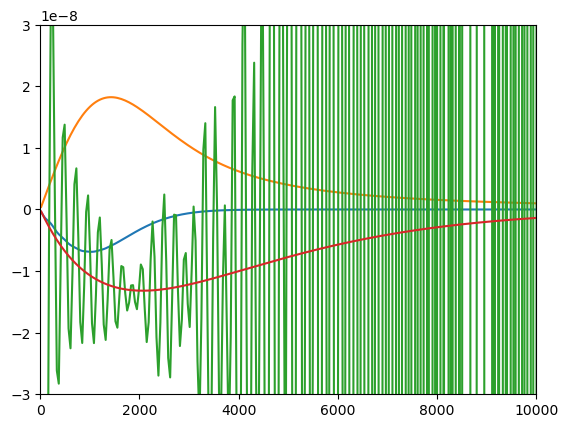

201 20.083510271379104 0.1 0.06308063295569537
202 20.183510271379106 0.1 0.06308741714354822
203 20.283510271379107 0.1 0.06315054408975179
204 20.38351027137911 0.1 0.06299478632947232
205 20.48351027137911 0.1 0.06312875014872213
206 20.58351027137911 0.1 0.06302188878339683
207 20.683510271379113 0.1 0.06300746793239242
208 20.783510271379114 0.1 0.0630863675641767
209 20.883510271379116 0.1 0.06292381088226462
210 20.983510271379117 0.1 0.06305291420452945
211 21.08351027137912 0.1 0.06295717927121416
212 21.18351027137912 0.1 0.06292942439922142
213 21.28351027137912 0.1 0.06301718254030121
214 21.383510271379123 0.1 0.06285131119227469
215 21.483510271379124 0.1 0.06297745233004162
216 21.583510271379126 0.1 0.0628870197231002
217 21.683510271379127 0.1 0.0628535816734066
218 21.78351027137913 0.1 0.06294441806076727
219 21.88351027137913 0.1 0.06277720969640939
220 21.98351027137913 0.1 0.06290331815584635
221 22.083510271379133 0.1 0.0628119666552319
222 22.183510271379134 0.1

/home/kklee/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in multiply
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


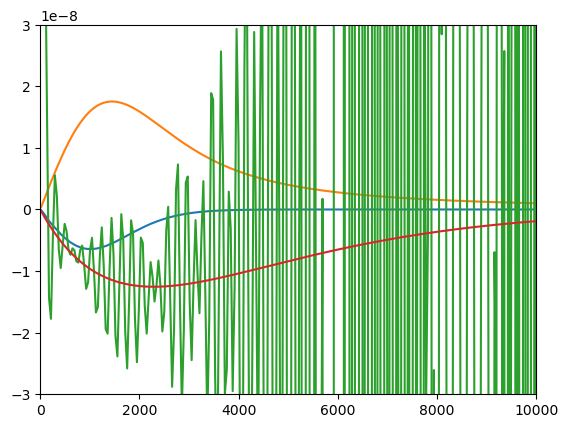

301 30.083510271379247 0.1 0.061519954623704576
302 30.183510271379248 0.1 0.06135659428331531
303 30.28351027137925 0.1 0.06150029519402694
304 30.38351027137925 0.1 0.061334193210380514
305 30.483510271379252 0.1 0.0614013612152841
306 30.583510271379254 0.1 0.06137048588081518
307 30.683510271379255 0.1 0.06127719541908185
308 30.783510271379257 0.1 0.06139048406865744
309 30.883510271379258 0.1 0.06120441071070259
310 30.98351027137926 0.1 0.061335300408411765
311 31.08351027137926 0.1 0.061210101256773404
312 31.183510271379262 0.1 0.0612162609162049
313 31.283510271379264 0.1 0.061247663129948365
314 31.383510271379265 0.1 0.061102971101737964
315 31.483510271379266 0.1 0.061241550096603176
316 31.583510271379268 0.1 0.061058449996370195
317 31.68351027137927 0.1 0.061156856989071674
318 31.78351027137927 0.1 0.061081685838716475
319 31.883510271379272 0.1 0.06102986022912501
320 31.983510271379274 0.1 0.06110995135740656
321 32.083510271379275 0.1 0.06093403501957046
322 32.1835

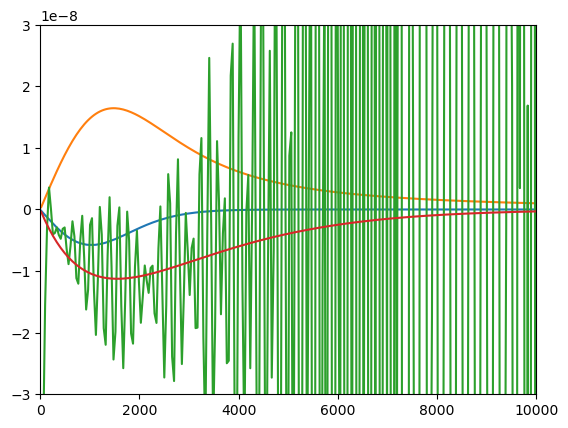

401 40.08351027137939 0.1 0.05882880341774609
402 40.18351027137939 0.1 0.05891390465041762
403 40.28351027137939 0.1 0.058726659514810285
404 40.38351027137939 0.1 0.058869943904692704
405 40.483510271379394 0.1 0.05868472491291101
406 40.583510271379396 0.1 0.05876628138358363
407 40.6835102713794 0.1 0.05869101555737848
408 40.7835102713794 0.1 0.05863421820636111
409 40.8835102713794 0.1 0.05870041986126134
410 40.9835102713794 0.1 0.05852418488707205
411 41.0835102713794 0.1 0.058666280723266
412 41.183510271379404 0.1 0.0584710337040825
413 41.283510271379406 0.1 0.05857205951701297
414 41.38351027137941 0.1 0.05847047023142174
415 41.48351027137941 0.1 0.05844192144308992
416 41.58351027137941 0.1 0.058482640570205864
417 41.68351027137941 0.1 0.05832394167658997
418 41.78351027137941 0.1 0.058459665429798385
419 41.883510271379414 0.1 0.05825758645164797
420 41.983510271379416 0.1 0.05837769916949185
421 42.08351027137942 0.1 0.05824739457406345
422 42.18351027137942 0.1 0.0582

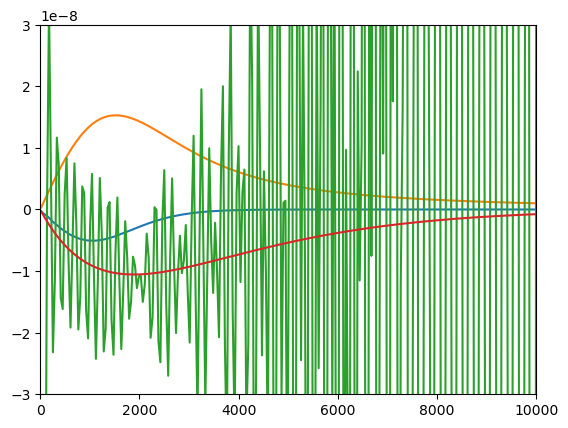

501 50.08351027137953 0.1 0.05601312731003795
502 50.18351027137953 0.1 0.05594300747017852
503 50.283510271379534 0.1 0.05602221321981445
504 50.383510271379535 0.1 0.05584494198486665
505 50.48351027137954 0.1 0.055995249108998
506 50.58351027137954 0.1 0.055793642411042586
507 50.68351027137954 0.1 0.05591901608590408
508 50.78351027137954 0.1 0.055788799964442685
509 50.88351027137954 0.1 0.05580724281055664
510 50.983510271379544 0.1 0.05580509543088676
511 51.083510271379545 0.1 0.05569292705180945
512 51.18351027137955 0.1 0.055806306310825865
513 51.28351027137955 0.1 0.05561043578379114
514 51.38351027137955 0.1 0.055764910695352284
515 51.48351027137955 0.1 0.05557700936342603
516 51.58351027137955 0.1 0.05567656598354735
517 51.683510271379554 0.1 0.05558368627621942
518 51.783510271379555 0.1 0.0555620920065348
519 51.883510271379556 0.1 0.055600466451460516
520 51.98351027137956 0.1 0.055456229055273046
521 52.08351027137956 0.1 0.055592570964388806
522 52.18351027137956 0

In [9]:
setupT()
setupQ()
setupV2Grav()
setupU1U2()
currentT = 0.0

#Record
centralDensity = []
R99 = []
ts = []
cfls = []
gravitationalForce = []
pressureGradient = []
quantumPressure = []

#Pertubation
oldGM = GM
newGM = GM*1.2

for t in range(bigT):
    #Pertubation
    if(currentT<6.0):
        GM = newGM
    if(currentT>=6.0):
        GM = oldGM

    setupQ()
    setupV2Grav()
    setupU1U2()
    psi = np.linalg.solve(U2, np.dot(U1,psi))

    print(t, currentT, dt, np.absolute(psi[0])/x[0])

    currentT = currentT + dt
    dt = min(0.1, 0.1*dx/abs((np.angle(psi[1])-np.angle(psi[0]))/(dx*Ra)/m/Ra/omegaA))

    #Record
    if(GM == oldGM):
        #Record
        rho0 = (np.absolute(psi[14])*np.absolute(psi[14])/x[14]/x[14])/Ra/Ra/Ra*totalMass
        rho1 = (np.absolute(psi[15])*np.absolute(psi[15])/x[15]/x[15])/Ra/Ra/Ra*totalMass
        rho2 = (np.absolute(psi[16])*np.absolute(psi[16])/x[16]/x[16])/Ra/Ra/Ra*totalMass
        rho3 = (np.absolute(psi[17])*np.absolute(psi[17])/x[17]/x[17])/Ra/Ra/Ra*totalMass
        Q0 = -((np.sqrt(rho0) -2*np.sqrt(rho1) + np.sqrt(rho2))/(dx*Ra)/(dx*Ra) + 2.0/(x[15]*Ra)*(np.sqrt(rho1)-np.sqrt(rho0))/(dx*Ra))/np.sqrt(rho1)/2.0/m
        Q1 = -((np.sqrt(rho1) -2*np.sqrt(rho2) + np.sqrt(rho3))/(dx*Ra)/(dx*Ra) + 2.0/(x[16]*Ra)*(np.sqrt(rho2)-np.sqrt(rho1))/(dx*Ra))/np.sqrt(rho2)/2.0/m

        cfls.append((np.angle(psi[1])-np.angle(psi[0]))/(dx*Ra)/m/Ra/omegaA*dt/dx)
        R99.append(findMass())
        centralDensity.append(np.absolute(psi[0])*np.absolute(psi[0])/x[0]/x[0])
        ts.append(currentT)
        gravitationalForce.append((phi[16]-phi[15])/dx)
        pressureGradient.append(4.0*np.pi*a/m/m/m*(rho2-rho1)/(dx*Ra)/Ra/omegaA/omegaA)
        quantumPressure.append((Q1-Q0)/m/(dx*Ra)/Ra/omegaA/omegaA)

    if t%100 == 0:
        #plt.plot(x, np.absolute(psi)*np.absolute(psi)/x/x)
        #Temporary
        #massInCU = 2e-77
        #aInCU = 1e-73
        #totalMassInCU = 0.1
        from scipy.optimize import curve_fit
        def func(x, a, b):
            return a * x * np.exp(-b * x)

        hBarInCU = 1.1977151493389159e-76
        setupV2Grav()
        np.set_printoptions(threshold=np.inf)

        rhoTemp = (np.absolute(psi)/x)*(np.absolute(psi)/x)/Ra/Ra/Ra*totalMass*5.1550e96*0.001*1.619e-18
        pressure = 2.0*np.pi*aInCU*hBarInCU*hBarInCU/massInCU/massInCU/massInCU*rhoTemp*rhoTemp
        pressureGradients = np.gradient(pressure, x*Ra*1.616e-35*100*6.77193e-6, edge_order=2)
        gravitationalPotential = phi*Ra*Ra*omegaA*omegaA*1.616e-35*100*6.77193e-6*1.616e-35*100*6.77193e-6/5.391e-44/5.391e-44/2.03017e5/2.03017e5

        dRhodx = np.gradient(np.sqrt(rhoTemp), x*Ra*1.616e-35*100*6.77193e-6, edge_order=2)
        d2Rhodx = np.gradient(dRhodx, x*Ra*1.616e-35*100*6.77193e-6, edge_order=2)
        quantumPotential = -hBarCU*hBarCU/2.0/massInCU*(d2Rhodx + 2.0/(x*Ra*1.616e-35*100*6.77193e-6)*dRhodx)/np.sqrt(rhoTemp)

        plt.plot(x*Ra*1.616e-35*100*6.77193e-6, pressureGradients/rhoTemp)
        plt.plot(x*Ra*1.616e-35*100*6.77193e-6, np.gradient(gravitationalPotential, x*Ra*1.616e-35*100*6.77193e-6, edge_order=2))

        plt.plot(x*Ra*1.616e-35*100*6.77193e-6, np.gradient(quantumPotential, x*Ra*1.616e-35*100*6.77193e-6)/massInCU)
        popt, pcov = curve_fit(func, x[15:100]*Ra*1.616e-35*100*6.77193e-6/1000, np.gradient(quantumPotential[15:100], x[15:100]*Ra*1.616e-35*100*6.77193e-6)/massInCU*1e8)
        print(popt)
        plt.plot(x*Ra*1.616e-35*100*6.77193e-6, func(x*Ra*1.616e-35*100*6.77193e-6/1000, *popt)/1e8)

        plt.xlim(0.0,10000.0)
        plt.ylim(-3e-8,3e-8)
        #print(np.gradient(quantumPotential[100:1500], x[100:1500]*Ra*1.616e-35*100*6.77193e-6)/massInCU)
        #print(x[100]*Ra*1.616e-35*100*6.77193e-6)
        plt.show()

#plt.xlabel(r"$r$ (dimensionless)")
#plt.ylabel(r"$\left | \psi^2 \right |$ (dimensionless)")
#plt.show()

In [ ]:
plt.plot(ts, centralDensity)
plt.xlabel(r"$t$ (dimensionless)")
plt.ylabel(r"$\left | \psi^2 \right |$ (dimensionless)")
plt.show()

In [ ]:
sp = np.fft.fft(centralDensity)
freq = np.fft.fftfreq(len(centralDensity), d=dt)*omegaA/5.391247e-44

plt.plot(freq, np.absolute(sp))
plt.xlim(0.01,0.4)
plt.ylim(0.0,5.0)
plt.xlabel("f (1/s)")

In [ ]:
print(freq[1]-freq[0])
for i in range(len(freq)-1):
    if(freq[i] > 0.0 and np.absolute(sp[i]) > 0.5 and np.absolute(sp[i])>np.absolute(sp[i+1]) and np.absolute(sp[i])>np.absolute(sp[i-1])):
        print(freq[i], np.absolute(sp[i]))

In [ ]:
plt.plot(ts, R99)
plt.xlabel(r"$t$ (dimensionless)")
plt.ylabel(r"R99")
plt.show()

In [ ]:
sp = np.fft.fft(R99)
freq = np.fft.fftfreq(len(R99), d=dt)*omegaA/5.391247e-44

plt.plot(freq, np.absolute(sp))
plt.xlim(0.01,0.4)
plt.ylim(0.0,100000)
plt.xlabel("f (1/s)")

In [ ]:
print(freq[1]-freq[0])
for i in range(len(freq)-1):
    if(freq[i] > 0.0 and np.absolute(sp[i]) > 10000 and np.absolute(sp[i])>np.absolute(sp[i+1]) and np.absolute(sp[i])>np.absolute(sp[i-1])):
        print(freq[i], np.absolute(sp[i]))

In [ ]:
plt.plot(x, np.absolute(psi)*np.absolute(psi)/x/x)
print(np.absolute(psi)/x)

In [ ]:
plt.plot(ts, cfls)
plt.xlabel(r"$t$ (dimensionless)")
plt.ylabel(r"cfl")
plt.ylim(-0.3,0.3)
plt.show()

In [ ]:
sp = np.fft.fft(pressureGradient)
freq = np.fft.fftfreq(len(pressureGradient), d=dt)*omegaA/5.391247e-44

sp2 = np.fft.fft(quantumPressure)

#for i in range(len(freq)):
#    if(freq[i]<=-10.0 or freq[i]>=10.0):
#        sp[i] = 0.0
#        sp2[i] = 0.0

pressureGradient = np.fft.ifft(sp)
quantumPressure = np.fft.ifft(sp2)

plt.plot(ts, gravitationalForce)
plt.plot(ts, pressureGradient)
plt.plot(ts, quantumPressure)
plt.plot(ts, gravitationalForce+pressureGradient)
plt.plot(ts, gravitationalForce+quantumPressure)
plt.xlabel(r"$t$ (dimensionless)")
plt.ylabel(r"Different Forces")
plt.show()

In [ ]:
sp = np.fft.fft(pressureGradient)
freq = np.fft.fftfreq(len(pressureGradient), d=dt)*omegaA/5.391247e-44

plt.plot(freq, np.absolute(sp))
#plt.xlim(0.01,0.4)
#plt.ylim(0.0,100000)
plt.xlabel("f (1/s)")

Middle
0.071-0.081			M1 (M2: 0.142-0.162, M3: 0.213-0.243, M4: 0.284-0.324, M5: 0.355-0.405)
0.132-0.137			M1?
0.158-0.163			M2
0.193-0.204			M1?
0.239-0.249			M3
0.295-0.305			M4
0.361-0.371			M5

0.076-0.086			M1
0.132-0.142			M1?
0.158-0.168			M2

Small
0.097-0.107		M1
0.163-0.173		M1?
0.214-0.224		M2
0.270-0.280		M1?
0.341-0.351		M3
0.432-0.443		M4
0.534-0.544		M5
0.651-0.661		M6

Heavy
0.031-0.037		M1
0.058-0.065		M2
0.072-0.078		M?
0.082-0.089		M?
0.099-0.167 	M3
0.116-0.123		M4
0.140-0.147		M5
0.167-0.173		M6?
0.194-0.201 	M7?